In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [3]:
data = pd.read_csv("dataset/preprocessed.csv")
data.shape

(762106, 44)

In [4]:
data = data.drop(data[data.target == -1].index)
data.shape

(762094, 44)

In [5]:
# Separate input features and target
targets = data.target
targets.head()

0    3
1    5
2    2
3    2
4    1
Name: target, dtype: int64

In [6]:
targets -= 1
targets.head()

0    2
1    4
2    1
3    1
4    0
Name: target, dtype: int64

In [7]:
targets = targets.to_numpy()

In [8]:
features = data.drop('target', axis=1)

In [9]:
features = features.to_numpy()

In [10]:
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 0)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.2, random_state = 0)

In [12]:
X_train.shape



(487740, 43)

In [13]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 50166  55949  87609 117459 176557]]


Text(0.5, 1.0, 'Unbalanced Data Distribution')

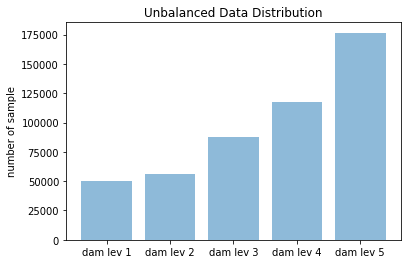

In [14]:
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('Unbalanced Data Distribution')

In [15]:
sm = SMOTETomek(random_state = 27, n_jobs = -1)

X_train, y_train = sm.fit_sample(X_train, y_train)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/imblearn/utils/deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


In [16]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [162635 155765 149211 144863 147975]]


Text(0.5, 1.0, 'After Re-sampling Data Distribution')

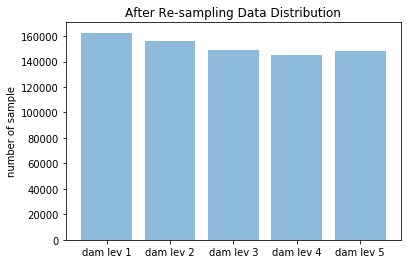

In [17]:
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('After Re-sampling Data Distribution')

In [18]:
X_train.shape





(760449, 43)

In [19]:
print((X_train ).shape)
print(( y_train).shape)


(760449, 43)
(760449,)


In [20]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
batch_size = 10000
epochs = 50
input_dim = 43
output_dim = 5
lr_rate = 0.01


In [22]:
class datasetLoad(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    


In [23]:
print(type(X_train))
X_train = datasetLoad(X_train, y_train)
X_val = datasetLoad(X_val, y_val)
# X_test = datasetLoad(X_test, y_test)

<class 'numpy.ndarray'>


In [24]:
print(type(X_train))
train_loader = torch.utils.data.DataLoader(dataset = X_train, batch_size = batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = X_val, batch_size = batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset = X_test, batch_size = batch_size, shuffle=True)

<class '__main__.datasetLoad'>


In [25]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs
    
    

In [26]:
model = LogisticRegression(input_dim, output_dim)

In [27]:
criterion = torch.nn.CrossEntropyLoss()


In [28]:
# sgd ya da adam kullanilabilir
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [29]:
if torch.cuda.is_available():
    print("cuda")
    model = model.cuda()
    criterion = criterion.cuda()

cuda


In [30]:
print(len(X_train))

760449


In [31]:
import datetime
a = datetime.datetime.now().replace(microsecond=0)
train_loss = []
validation_loss = []
for epoch in range(epochs):
    train_loss_val = 0.0
    num_of_train_iter = 0
    for i, (train_feature, train_label) in enumerate(train_loader):
        train_feature = Variable(train_feature)
        train_label = Variable(train_label)
        if torch.cuda.is_available():
            train_feature = train_feature.cuda()
            train_label = train_label.cuda() 
        optimizer.zero_grad()
        outputs = model(train_feature.float())
        loss = criterion(outputs.float(), train_label)
        loss.backward()
        optimizer.step()
        train_loss_val += loss.item()
        num_of_train_iter = i
        del train_feature
        del train_label        
        torch.cuda.empty_cache()
    train_loss_val /= num_of_train_iter

        
    validation_loss_val = 0.0
    num_of_val_iter = 0
        
    # calculate Accuracy
    correct = 0.0
    total = 0
    accuracy = 0.0
    for i, (features, labels) in enumerate( val_loader):
        features = Variable(features)
        labels = Variable(labels)
        if torch.cuda.is_available():
            features = features.cuda()
            labels = labels.cuda() 
        with torch.no_grad():
            outputs = model(features.float())
        loss = criterion(outputs.float(), labels)
        validation_loss_val += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
        accuracy += 100 * correct/total
        num_of_val_iter = i
        del features
        del labels        
        torch.cuda.empty_cache()
    validation_loss_val /= num_of_val_iter
    accuracy /=  num_of_val_iter
    
    train_loss.append(train_loss_val)
    validation_loss.append(validation_loss_val)
    if(epoch % 5 == 0):   
        print("{")
        print("Epoch: {}. Train Loss: {}. ".format(epoch, train_loss_val))
        print("Epoch: {}. Validation Loss: {}. Validation Accuracy: {}.".format(epoch, validation_loss_val, accuracy))
        print("}")


{
Epoch: 0. Train Loss: 1.6283476603658575. 
Epoch: 0. Validation Loss: 1.661226620276769. Validation Accuracy: 35.122314453125.
}
{
Epoch: 5. Train Loss: 1.422559347591902. 
Epoch: 5. Validation Loss: 1.5307888587315877. Validation Accuracy: 41.24092483520508.
}
{
Epoch: 10. Train Loss: 1.3947865053227073. 
Epoch: 10. Validation Loss: 1.511972814798355. Validation Accuracy: 43.07335662841797.
}
{
Epoch: 15. Train Loss: 1.3842540571564121. 
Epoch: 15. Validation Loss: 1.5078479945659637. Validation Accuracy: 43.483116149902344.
}
{
Epoch: 20. Train Loss: 1.3797814061767177. 
Epoch: 20. Validation Loss: 1.506134917338689. Validation Accuracy: 43.70792770385742.
}
{
Epoch: 25. Train Loss: 1.3766902747907137. 
Epoch: 25. Validation Loss: 1.5069701770941417. Validation Accuracy: 43.90155029296875.
}
{
Epoch: 30. Train Loss: 1.3752039937596572. 
Epoch: 30. Validation Loss: 1.5062110523382823. Validation Accuracy: 43.71706771850586.
}
{
Epoch: 35. Train Loss: 1.37441401575741. 
Epoch: 35. Va

In [32]:
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)

0:04:36


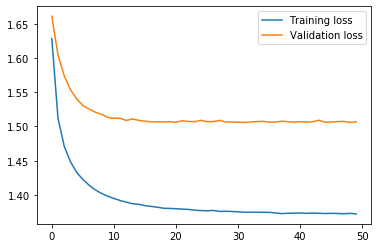

In [33]:
# plotting the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.legend()
plt.show()

In [34]:
X_test  = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [35]:
if torch.cuda.is_available():
    X_test = X_test.cuda()
    y_test = y_test.cuda() 

In [36]:
with torch.no_grad():
    outputs = model(X_test.float())
_, predicted = torch.max(outputs.data, 1)


In [37]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(predicted.cpu().numpy(),y_test.cpu())
accuracy*100

39.853955215557114

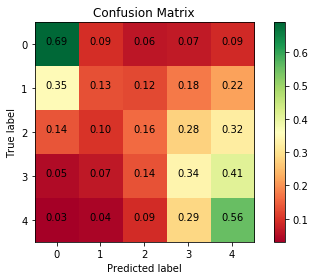

array([[0.69008704, 0.09293005, 0.06199512, 0.06687958, 0.08810821],
       [0.35087014, 0.1322727 , 0.12497846, 0.17500431, 0.21687439],
       [0.13704221, 0.10097073, 0.16123695, 0.27728342, 0.32346669],
       [0.04838096, 0.06598392, 0.13609692, 0.33888406, 0.41065413],
       [0.03060093, 0.03875997, 0.09002199, 0.2852574 , 0.55535971]])

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.cpu(), predicted.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
plt.show()
cm